In [32]:
import pandas as pd
import argparse
import random
import time
import os
import duckdb
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from crptmidfreq.config_loc import *
from crptmidfreq.featurelib.lib_v1 import *
from crptmidfreq.strats import *
from crptmidfreq.utils.common import to_csv
from crptmidfreq.utils.univ import hardcoded_universe_1
plt.style.use('ggplot')


g_folder = 'res_exploration_v2'
g_reg = StepperRegistry()
clean_folder(g_folder)

2025-04-03 09:16:50 - Cleaning folder res_exploration_v2


In [ ]:
unit_day = 60*24
cfg = dict(
        #windows_macd_turnover=[[1_000, 10_000]],
        windows_macd_turnover=[[2*60, 24*60]],

        window_volume_wgt=60*24*30,
        window_volume_univ=60*24*20,

        windows_ewm=[20],

)
defargs = {'folder':g_folder,'name':None,'r':g_reg,'cfg':cfg}
defargs2 = {'folder':g_folder,'name':None,'r':g_reg}
featd=prepare_klines(start_date='2024-09-01',
                   end_date='2026-01-01',
                   #hardcoded_universe_1,#['ETHUSDT','BTCUSDT','BNBUSDT'], # ,'ADAUSDT'
                   tokens=['ETHUSDT','BTCUSDT','SOLUSDT','BNBUSDT'],# ,'ADAUSDT'
                   **defargs)

featd['turnover_log']=np.log(1+featd['turnover'])
featd['univ'] = np.ones_like(featd['dtsi'],dtype=np.int64)

featd=turnover_excess(featd,**defargs)

# forward_fh1 definition
# and tret_xmkt definition
featd = define_forward_fh(featd,
                        incol='tret',
                        **defargs)

# defining tret_xmkt
incol='tret'
featd = remove_mkt(featd,
                incol=incol,
                outcol=f'{incol}_xmkt',
                with_clip=False,
                **defargs)
featd['tret_xmkt']=np.log(1+featd['tret_xmkt'])

2025-04-03 09:16:50 - Missing key=use_lazy_dict in cfg for kmeans_sret -- will use default value
2025-04-03 09:16:50 - prepare_klines start_date=2024-09-01 end_date=2026-01-01
2025-04-03 09:16:50 - Reading data from DuckDB


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2025-04-03 09:17:04 - Stepper creating instance res_exploration_v2 None_cnt_exists
2025-04-03 09:17:06 - Stepper creating instance res_exploration_v2 None_close_diff1
2025-04-03 09:17:07 - Stepper creating instance res_exploration_v2 None_tret_clip
2025-04-03 09:17:09 - Stepper creating instance res_exploration_v2 None_turnover_ewm43200
2025-04-03 09:17:10 - Stepper creating instance res_exploration_v2 None_turnover_ewm43200_qtl
2025-04-03 09:17:12 - Missing key=window_appops in cfg for pnl_feats -- will use default value
2025-04-03 09:17:12 - Stepper creating instance res_exploration_v2 None_turnover_log_diff1
2025-04-03 09:17:12 - Stepper creating instance res_exploration_v2 None_turnover_log_diff1_csmeanNoneNone
2025-04-03 09:17:13 - Stepper creating instance res_exploration_v2 None_turnover_log_diff1_csdemean_cumsum
2025-04-03 09:17:14 - Stepper creating instance res_exploration_v2 None_turnover_log_diff1_csdemean_cumsum_ewm100_macd
2025-04-03 09:17:14 - Stepper creating instance r

In [34]:
turnover_excess_col=[x for x in get_sigf_cols(featd) if x.startswith('sigf_turnover_log_diff1_csdemean_cumsum_macd')][0]
print(turnover_excess_col)
featd['sret']=featd['tret_xmkt']
adjs = np.clip(np.exp(20*featd[turnover_excess_col]),a_min=0.1,a_max=10.0)
print(pd.Series(adjs).describe().round(2))
featd['sret_div']=np.where(adjs>1,featd['tret_xmkt']/adjs,featd['tret_xmkt'])
featd['sret_mult']=featd['tret_xmkt']*adjs

sigf_turnover_log_diff1_csdemean_cumsum_macd100x1000
count    1208160.00
mean           3.15
std            3.98
min            0.10
25%            0.11
50%            0.77
75%            6.35
max           10.00
dtype: float64


In [35]:
featd = mr_mual_feats(featd,
                          feats=['sret_mult'],
                          outname='mual_mult',
                          **defargs)
featd = mr_mual_feats(featd,
                          feats=['sret_div'],
                          outname='mual_div',
                          **defargs)
featd = mr_mual_feats(featd,
                          feats=['sret'],
                          outname='mual',
                          **defargs)

# Converting sigf to sig
for col in get_sigf_cols(featd):
    if 'mual' not in col:
        continue
    ncol = col.replace('sigf_', 'sig_')
    featd = rename_key(featd, col, ncol)

# Actual backtest
stats = perform_bktest(featd, **defargs2)


2025-04-03 09:17:26 - Stepper creating instance res_exploration_v2 None_sret_mult_ewm20
2025-04-03 09:17:26 - Stepper creating instance res_exploration_v2 None_sret_mult_ewmstd80
2025-04-03 09:17:29 - Stepper creating instance res_exploration_v2 None_todel_sret_mult_ewm20divmual_mult_std_clip
2025-04-03 09:17:29 - Stepper creating instance res_exploration_v2 None_todel_sret_mult_ewm20divmual_mult_std_clip_csstdNonewgt
2025-04-03 09:17:30 - Stepper creating instance res_exploration_v2 None_mual_mult_temp_clip
2025-04-03 09:17:32 - Stepper creating instance res_exploration_v2 None_sret_div_ewm20
2025-04-03 09:17:32 - Stepper creating instance res_exploration_v2 None_sret_div_ewmstd80
2025-04-03 09:17:34 - Stepper creating instance res_exploration_v2 None_todel_sret_div_ewm20divmual_div_std_clip
2025-04-03 09:17:35 - Stepper creating instance res_exploration_v2 None_todel_sret_div_ewm20divmual_div_std_clip_csstdNonewgt
2025-04-03 09:17:37 - Stepper creating instance res_exploration_v2 Non

Gross P&L Stats:
          name            col  sr_net  rpt_net  rog_net    sr   rpt    mdd  \
2  None_bktest  sig_mual_mult  -36.47    -0.87  -592.70  5.65  0.13  23.35   
1  None_bktest   sig_mual_div  -35.32    -0.86  -557.14  5.92  0.14  20.98   
0  None_bktest       sig_mual  -34.11    -0.85  -536.58  6.25  0.15  21.98   

     rog  avg_gmv   ann_pnl     cnt  nbstk  commbps          sd          ed  
2  91.70      NaN  22848.65  244800    NaN      1.0  2024-09-01  2025-03-11  
1  93.25      NaN  24702.58  244800    NaN      1.0  2024-09-01  2025-03-11  
0  98.20      NaN  26015.87  244800    NaN      1.0  2024-09-01  2025-03-11  
Saved : /Users/sachadrevet/data_tmp/analysis/None_bktest_bktest_stats.csv


<Axes: xlabel='daily_dt'>

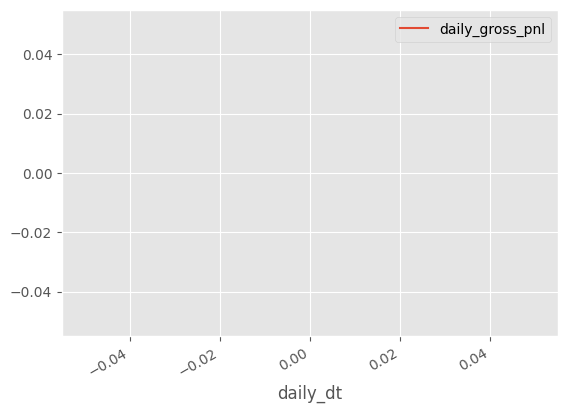

In [36]:
dailypnl=stats.dailypnl.copy()
dailypnl['daily_dt']=pd.to_datetime(dailypnl['daily_dt']*1e3)
dailypnl.loc[lambda x:x['colname']=='sig_zs_20']\
    .set_index('daily_dt')[['daily_gross_pnl']].cumsum().plot()

close
tret_xmkt
sret
sret_div
sret_mult
sigf_turnover_log_diff1_csdemean_cumsum_macd100x1000


<Axes: title={'center': 'sigf_turnover_log_diff1_csdemean_cumsum_macd100x1000'}, xlabel='close_time'>

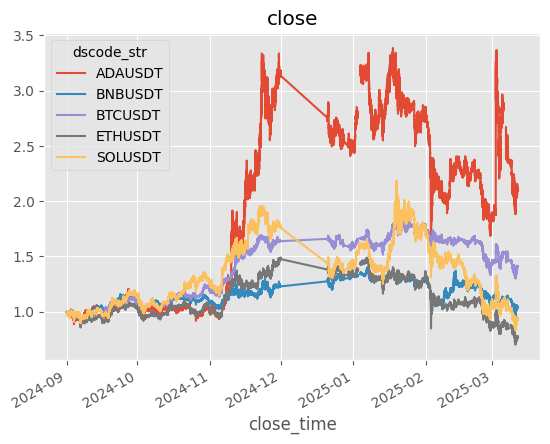

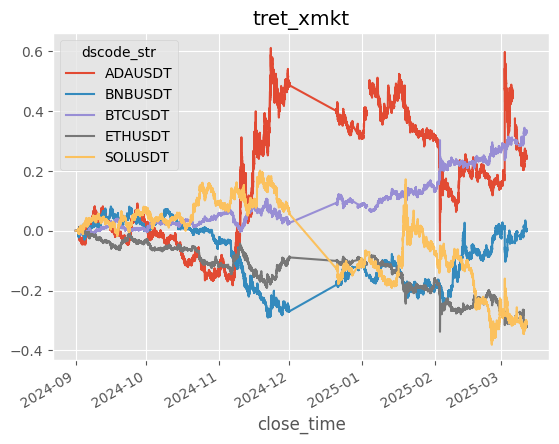

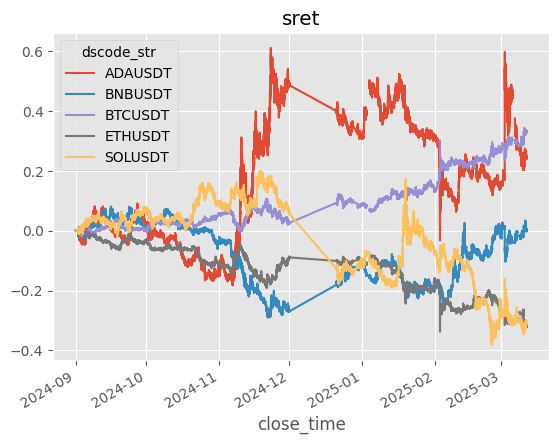

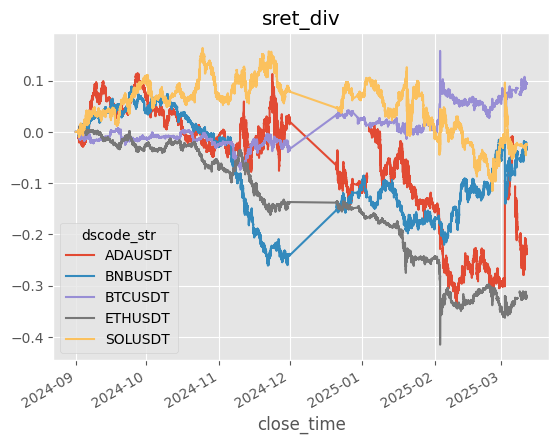

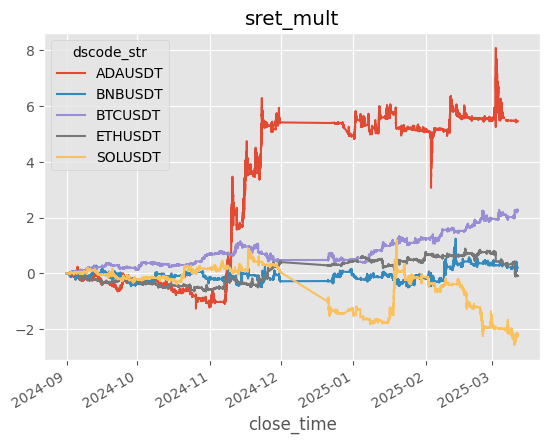

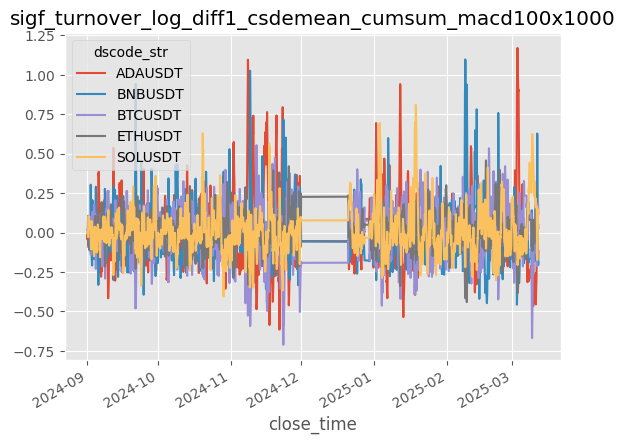

In [37]:
df = pd.DataFrame({k: featd[k] for k in featd.keys()})
col='close'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf=pdf/pdf.iloc[0]
pdf.plot(title=col)
col='tret_xmkt'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.cumsum().plot(title=col)


col='sret'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.cumsum().plot(title=col)

col='sret_div'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.cumsum().plot(title=col)


col='sret_mult'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.cumsum().plot(title=col)

col=turnover_excess_col
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.ewm(halflife=100).mean().plot(title=col)

In [38]:
df[['sig_mual_div','sig_mual_mult','sig_mual']].corr()

,sig_mual_div,sig_mual_mult,sig_mual
sig_mual_div,1.000000,0.581916,0.915339
sig_mual_mult,0.581916,1.000000,0.778389
sig_mual,0.915339,0.778389,1.000000


sig_mual_div
sig_mual_mult


<Axes: title={'center': 'sig_mual_mult'}, xlabel='close_time'>

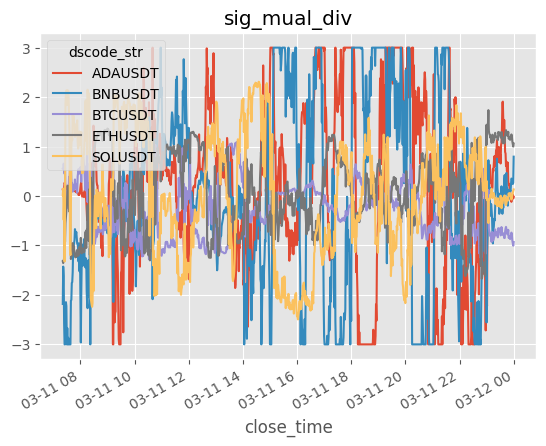

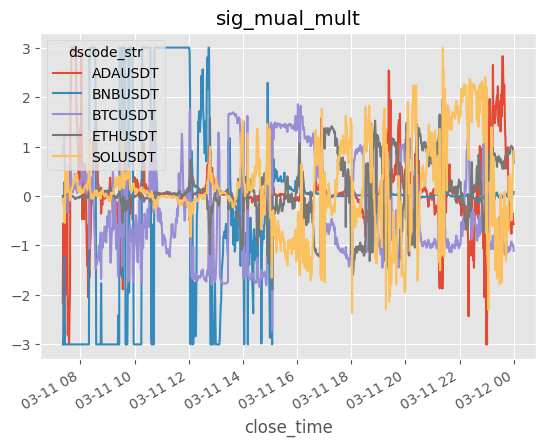

In [39]:

col='sig_mual_div'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.tail(1000).plot(title=col)

col='sig_mual_mult'
print(col)
pdf=df.pivot_table(index='close_time',columns='dscode_str',values=col)
pdf.tail(1000).plot(title=col)


In [40]:
pd.Series(featd.keys())

0                                            close_time
1                                                dscode
2                                                 close
3                                                volume
4                                      taker_buy_volume
5                                            dscode_str
6                                                  dtsi
7                                           sigf_dscode
8                                              turnover
9                                                   one
10                                               ipocnt
11                                       sigf_timeofday
12                                       sigf_dayofweek
13                                          close_diff1
14                                                 tret
15                                          tret_qtllow
16                                         tret_qtlhigh
17                                         tret_